In [2]:
from random import random

import numpy as np
import pandas as pd
import pickle
import umap.umap_ as umap
import hdbscan
from collections import Counter
from tqdm import tqdm
from sklearn.metrics import silhouette_score
import sklearn.cluster as cluster
from hdbscan.flat import HDBSCAN_flat
from config import OUTPUT_WITH_EMBEDDING_PICKLE_PATH, WHY_NOT_ETHICAL_CLEAN_TEXT_COLUMN, RISK_1_COLUMN, DISTIL_ROBERTA_EMBEDDING_COLUMN, MPNET_EMBEDDING_COLUMN, LEGAL_BERT_EMBEDDING_COLUMN
from data_preperation import _leave_only_main_risks
from matplotlib import pyplot as plt

In [7]:
with open(OUTPUT_WITH_EMBEDDING_PICKLE_PATH, "rb") as f:
    df = pickle.load(f)
df = df[
    [WHY_NOT_ETHICAL_CLEAN_TEXT_COLUMN, RISK_1_COLUMN, DISTIL_ROBERTA_EMBEDDING_COLUMN, LEGAL_BERT_EMBEDDING_COLUMN,
     MPNET_EMBEDDING_COLUMN]]

df = _leave_only_main_risks(df) # todo: try different
df.shape, Counter(df[RISK_1_COLUMN]).most_common()

((5018, 5),
 [('dp&p uninformed consent', 1264),
  ('onesided terms', 1172),
  ('collection of personal data', 526),
  ('other limitation of liability', 477),
  ('third party data transfers', 457),
  ('limited readability', 417),
  ('limitation of liability', 259),
  ('unfair terms', 239),
  ('storage and retention of personal data', 207)])

Find K means best number of clusters


100%|██████████| 39/39 [01:47<00:00,  2.76s/it]


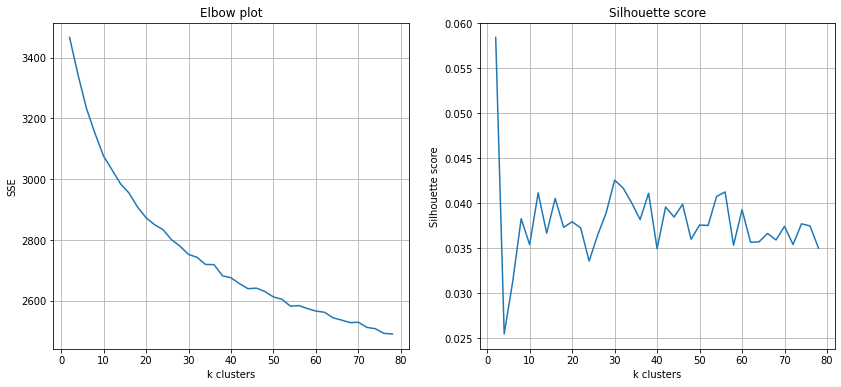

In [11]:
from evaluation_utils import plot_kmeans_inertia_and_silhouette

print("Find K means best number of clusters")
plot_kmeans_inertia_and_silhouette(list(df[DISTIL_ROBERTA_EMBEDDING_COLUMN]), range(2, 80, 2))

In [12]:
from evaluation_utils import random_search




space = {
    "min_cluster_size": range(100, 300),
    "min_samples": range(2, 100)
}

random_search(list(df[DISTIL_ROBERTA_EMBEDDING_COLUMN]), space, num_evals=100).head(20)

,run_id,min_cluster_size,min_samples,label_count,cost
61,61,102,3,3,0.821244
0,0,248,98,1,1.000000
72,72,260,77,1,1.000000
71,71,251,52,1,1.000000
70,70,294,56,1,1.000000
69,69,181,77,1,1.000000
68,68,278,64,1,1.000000
67,67,297,31,1,1.000000
66,66,266,44,1,1.000000
65,65,230,79,1,1.000000


In [14]:
from evaluation_utils import generate_clusters, score_clusters, bayesian_search

clusters_default = generate_clusters(list(df[DISTIL_ROBERTA_EMBEDDING_COLUMN]),
                                     umap_n_neighbors = 15,
                                     umap_n_components = 5,
                                     hdbscan_min_cluster_size = 10,
                                     random_state=42)

labels_def, cost_def, silhouette = score_clusters(list(df[DISTIL_ROBERTA_EMBEDDING_COLUMN]), clusters_default)
print(labels_def, cost_def, silhouette)



66 0.41470705460342766 -0.02110852


In [15]:
%%time

space = {
        "n_neighbors": range(3,100),
        "n_components": range(3,200),
        "min_cluster_size": range(20,300),
        "random_state": 42
    }

random_use = random_search(list(df[DISTIL_ROBERTA_EMBEDDING_COLUMN]), space, 100)
random_use.head(25)

100%|██████████| 100/100 [1:09:11<00:00, 41.52s/it]

CPU times: user 1h 27min 53s, sys: 11min 11s, total: 1h 39min 4s
Wall time: 1h 9min 11s


,run_id,n_neighbors,n_components,min_cluster_size,label_count,cost,silhouette
76,76,42,64,139,6,0.460741,0.001762
93,93,37,121,217,4,0.425070,0.003686
46,46,46,192,166,5,0.460343,0.003739
15,15,33,159,168,5,0.459546,0.003878
32,32,70,133,153,5,0.460741,0.003958
39,39,19,135,143,5,0.445795,0.003960
3,3,82,133,215,4,0.417098,0.004216
92,92,65,81,141,5,0.452969,0.004676
79,79,66,9,149,5,0.460343,0.005047
41,41,46,112,151,5,0.447788,0.005311


In [16]:
from hyperopt import fmin, tpe, hp, STATUS_OK, space_eval, Trials

hspace = {
    "n_neighbors": hp.choice('n_neighbors', range(3,100)),
    "n_components": hp.choice('n_components', range(3,200)),
    "min_cluster_size": hp.choice('min_cluster_size', range(20,300)),
    "random_state": 42
}

label_lower = 3
label_upper = 20
max_evals = 100

best_params_roberta, best_clusters_roberta, trials_roberta = bayesian_search(list(df[DISTIL_ROBERTA_EMBEDDING_COLUMN]),
                                                                 space=hspace,
                                                                 label_lower=label_lower,
                                                                 label_upper=label_upper,
                                                                 max_evals=max_evals)

100%|██████████| 100/100 [1:12:45<00:00, 43.66s/trial, best loss: 0.005779194898365883]
best:
{'min_cluster_size': 46, 'n_components': 147, 'n_neighbors': 29, 'random_state': 42}
label count: 4


In [17]:
trials_roberta.best_trial

{'state': 2,
 'tid': 25,
 'spec': None,
 'result': {'loss': 0.005779194898365883,
  'label_count': 4,
  'silhouette': -0.019588975,
  'status': 'ok'},
 'misc': {'tid': 25,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'min_cluster_size': [25],
   'n_components': [25],
   'n_neighbors': [25]},
  'vals': {'min_cluster_size': [26],
   'n_components': [144],
   'n_neighbors': [26]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2022, 6, 19, 21, 47, 2, 516000),
 'refresh_time': datetime.datetime(2022, 6, 19, 21, 47, 55, 542000)}

In [33]:
best_clusters_roberta

HDBSCAN(min_cluster_size=46)

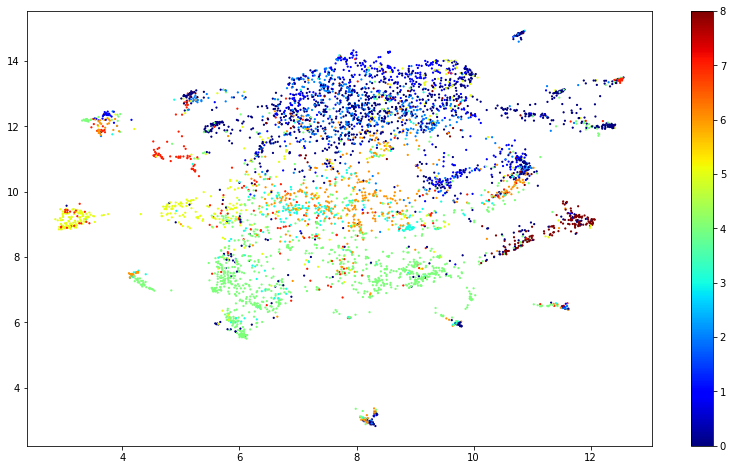

{0: 'dp&p uninformed consent', 1: 'collection of personal data', 2: 'third party data transfers', 3: 'limitation of liability', 4: 'onesided terms', 5: 'limited readability', 6: 'other limitation of liability', 7: 'unfair terms', 8: 'storage and retention of personal data'}


In [39]:
from evaluation_utils import plot_gt_clusters, plot_clusters, summarize_results, combine_results

true_labels_with_description = list(df[RISK_1_COLUMN])
numerical_values_to_description = dict(enumerate(set(true_labels_with_description)))
description_to_numerical_values = {value: key for key, value in numerical_values_to_description.items()}
true_labels = [description_to_numerical_values[label_with_description] for label_with_description in true_labels_with_description]
plot_gt_clusters(list(df[DISTIL_ROBERTA_EMBEDDING_COLUMN]), true_labels, n_neighbors=15, min_dist=0.1)
print(numerical_values_to_description)

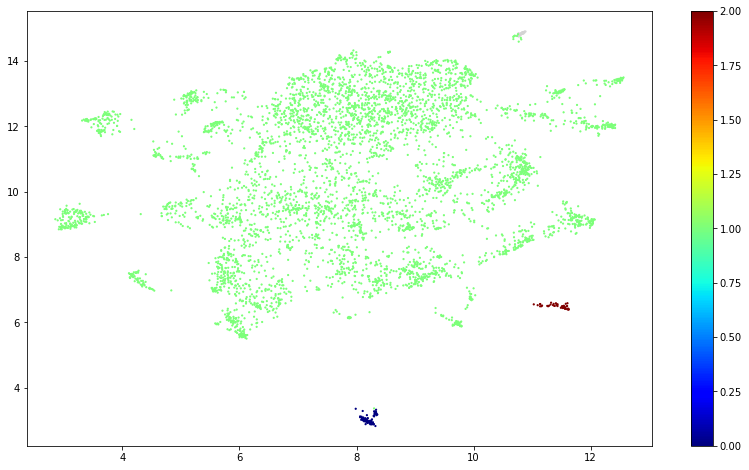

In [18]:
plot_clusters(list(df[DISTIL_ROBERTA_EMBEDDING_COLUMN]), best_clusters_roberta)

In [19]:
best_params_mpnet, best_clusters_mpnet, trials_mpnet = bayesian_search(list(df[MPNET_EMBEDDING_COLUMN]),
                                                                 space=hspace,
                                                                 label_lower=label_lower,
                                                                 label_upper=label_upper,
                                                                 max_evals=max_evals)

100%|██████████| 100/100 [1:13:39<00:00, 44.19s/trial, best loss: 0.0]               
best:
{'min_cluster_size': 40, 'n_components': 58, 'n_neighbors': 46, 'random_state': 42}
label count: 3


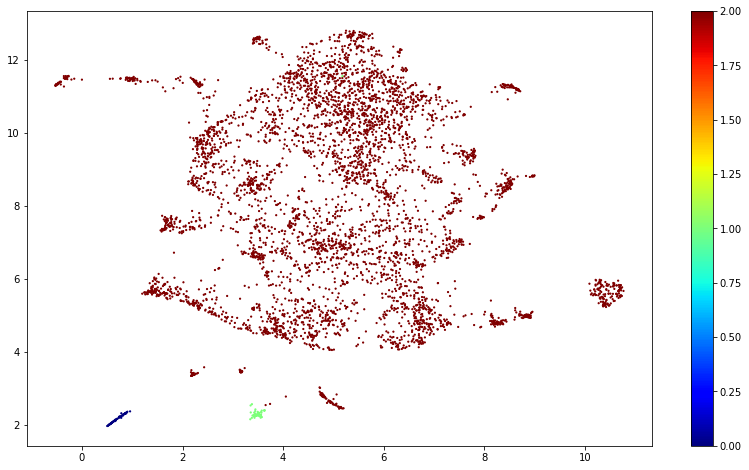

In [20]:
plot_clusters(list(df[MPNET_EMBEDDING_COLUMN]), best_clusters_mpnet)

In [22]:
cluster_dict = {'label_roberta': best_clusters_roberta,
                'label_mpnet': best_clusters_mpnet,
                }

results_df = combine_results(df, cluster_dict)

results_df.head()

,why.not.ethical_clean,Risk 1,distilroberta_embedding,legalbert_embedding,mpnet_embedding,label_roberta,label_mpnet
5,You should be able to have a little ownership ...,limitation of liability,"[0.006732163, 0.04000897, 0.008550427, -0.0195...","[-0.044874743, 0.08523971, -0.15401377, 0.0756...","[-0.014919908, 0.17370644, -0.02699172, 0.0909...",1,2
6,It says it will share your personal information.,limitation of liability,"[-0.021975141, -0.03166411, 0.029938562, -0.00...","[0.020037657, -0.0007348765, 0.03253959, 0.132...","[0.017846318, 0.00579677, 0.0020958597, -0.006...",1,2
12,The app should be involved in every dispute th...,third party data transfers,"[0.034794033, 0.049757995, 0.011505873, 0.0206...","[0.21883453, 0.24527611, -0.038958527, -0.0913...","[0.08813768, 0.03427214, -0.029278755, 0.03091...",1,2
39,Does not stipulate how they will find out some...,third party data transfers,"[-0.004343711, -0.046778727, -0.027114853, -0....","[-0.2642525, -0.07019935, 0.1605993, 0.0201278...","[0.014006895, 0.015158339, -0.029502647, -0.01...",1,2
49,It is putting sole responsibility on unauthori...,third party data transfers,"[0.027998101, 0.025162742, 0.010505822, 0.0599...","[-0.10262047, 0.25592512, 0.032078594, -0.0904...","[0.048196137, -0.04180213, 0.0023863602, 0.004...",1,2


In [23]:
import collections
import spacy

# Load English tokenizer, tagger, parser and NER
nlp = spacy.load("en_core_web_sm")



def get_group(df, category_col, category):
    """
    Returns documents of a single category

    Arguments:
        df: pandas dataframe of documents
        category_col: str, column name corresponding to categories or clusters
        category: int, cluster number to return
    Returns:
        single_category: pandas dataframe with documents from a single category
    """

    single_category = df[df[category_col]==category].reset_index(drop=True)

    return single_category


def most_common(lst, n_words):
    """
    Get most common words in a list of words

    Arguments:
        lst: list, each element is a word
        n_words: number of top common words to return

    Returns:
        counter.most_common(n_words): counter object of n most common words
    """
    counter=collections.Counter(lst)
    return counter.most_common(n_words)


def extract_labels(category_docs, print_word_counts=False):
    """
    Extract labels from documents in the same cluster by concatenating
    most common verbs, ojects, and nouns

    Argument:
        category_docs: list of documents, all from the same category or
                       clustering
        print_word_counts: bool, True will print word counts of each type in this category

    Returns:
        label: str, group label derived from concatentating most common
               verb, object, and two most common nouns

    """

    verbs = []
    dobjs = []
    nouns = []
    adjs = []

    verb = ''
    dobj = ''
    noun1 = ''
    noun2 = ''

    # for each document, append verbs, dobs, nouns, and adjectives to
    # running lists for whole cluster
    for i in range(len(category_docs)):
        doc = nlp(category_docs[i])
        for token in doc:
            if token.is_stop==False:
                if token.dep_ == 'ROOT':
                    verbs.append(token.text.lower())

                elif token.dep_=='dobj':
                    dobjs.append(token.lemma_.lower())

                elif token.pos_=='NOUN':
                    nouns.append(token.lemma_.lower())

                elif token.pos_=='ADJ':
                    adjs.append(token.lemma_.lower())

    # for printing out for inspection purposes
    if print_word_counts:
        for word_lst in [verbs, dobjs, nouns, adjs]:
            counter=collections.Counter(word_lst)
            print(counter)

    # take most common words of each form
    if len(verbs) > 0:
        verb = most_common(verbs, 1)[0][0]

    if len(dobjs) > 0:
        dobj = most_common(dobjs, 1)[0][0]

    if len(nouns) > 0:
        noun1 = most_common(nouns, 1)[0][0]

    if len(set(nouns)) > 1:
        noun2 = most_common(nouns, 2)[1][0]

    # concatenate the most common verb-dobj-noun1-noun2 (if they exist)
    label_words = [verb, dobj]

    for word in [noun1, noun2]:
        if word not in label_words:
            label_words.append(word)

    if '' in label_words:
        label_words.remove('')

    label = '_'.join(label_words)

    return label



def get_top_category(df_label, df_summary):
    """
    Returns a dataframe comparing a single model's results to ground truth
    label to evalute cluster compositions and derived label relative to labels
    and counts of most commmon ground truth category

    Arguments:
        df_label: pandas dataframe, each row as a document with extracted and ground truth labels
                  (result of `combine_ground_truth` function)
        df_summary: pandas dataframe with model cluster assignment, number
                    of documents in each cluster and derived labels
                    (result from `apply_and_summarize_labels` function)

    Returns:
        df_result: pandas dataframe with each row containing information on
                   each cluster identified by this model, including count,
                   extracted label, most represented ground truth label name,
                   count and percentage of that group
    """
    df_label_ground = (df_label.groupby('label')
                      .agg(top_ground_category=('category', lambda x:x.value_counts().index[0]),
                           top_cat_count = ('category', lambda x:x.value_counts()[0]))
                      .reset_index())

    df_result = pd.merge(df_summary, df_label_ground, on='label', how='left')
    df_result['perc_top_cat'] = df_result.apply(lambda x: int(round(100*x['top_cat_count']/x['count'])), axis=1)

    return df_result

def combine_ground_truth(df_clusters, df_ground, key):
    """
    Combines dataframes of documents with extracted and ground truth labels

    Arguments:
        df_clusters: pandas dataframe, each row as a document with corresponding extracted label
        df_ground: pandas dataframe, each row as a document with corresponding ground truth label
        key: str, key to merge tables on

    Returns:
        df_combined: pandas dataframe, each row as a document with extracted and ground truth labels
    """
    df_combined = pd.merge(df_clusters, df_ground, on=key, how = 'left')
    return df_combined



def get_top_category(df_label, df_summary):
    """
    Returns a dataframe comparing a single model's results to ground truth
    label to evalute cluster compositions and derived label relative to labels
    and counts of most commmon ground truth category

    Arguments:
        df_label: pandas dataframe, each row as a document with extracted and ground truth labels
                  (result of `combine_ground_truth` function)
        df_summary: pandas dataframe with model cluster assignment, number
                    of documents in each cluster and derived labels
                    (result from `apply_and_summarize_labels` function)

    Returns:
        df_result: pandas dataframe with each row containing information on
                   each cluster identified by this model, including count,
                   extracted label, most represented ground truth label name,
                   count and percentage of that group
    """
    df_label_ground = (df_label.groupby('label')
                      .agg(top_ground_category=(RISK_1_COLUMN, lambda x:x.value_counts().index[0]),
                           top_cat_count = (RISK_1_COLUMN, lambda x:x.value_counts()[0]))
                      .reset_index())

    df_result = pd.merge(df_summary, df_label_ground, on='label', how='left')
    df_result['perc_top_cat'] = df_result.apply(lambda x: int(round(100*x['top_cat_count']/x['count'])), axis=1)

    return df_result



def apply_and_summarize_labels(df, category_col):
    """
    Assign groups to original documents and provide group counts

    Arguments:
        df: pandas dataframe of original documents of interest to
            cluster
        category_col: str, column name corresponding to categories or clusters

    Returns:
        summary_df: pandas dataframe with model cluster assignment, number
                    of documents in each cluster and derived labels
    """

    numerical_labels = df[category_col].unique()

    # create dictionary of the numerical category to the generated label
    label_dict = {}
    for label in numerical_labels:
        current_category = list(get_group(df, category_col, label)[WHY_NOT_ETHICAL_CLEAN_TEXT_COLUMN])
        label_dict[label] = extract_labels(current_category)

    # create summary dataframe of numerical labels and counts
    summary_df = (df.groupby(category_col)[WHY_NOT_ETHICAL_CLEAN_TEXT_COLUMN].count()
                    .reset_index()
                    .rename(columns={WHY_NOT_ETHICAL_CLEAN_TEXT_COLUMN:'count'})
                    .sort_values('count', ascending=False))

    # apply generated labels
    summary_df['label'] = summary_df.apply(lambda x: label_dict[x[category_col]], axis = 1)

    return summary_df

In [24]:
results_df.head()

,why.not.ethical_clean,Risk 1,distilroberta_embedding,legalbert_embedding,mpnet_embedding,label_roberta,label_mpnet
5,You should be able to have a little ownership ...,limitation of liability,"[0.006732163, 0.04000897, 0.008550427, -0.0195...","[-0.044874743, 0.08523971, -0.15401377, 0.0756...","[-0.014919908, 0.17370644, -0.02699172, 0.0909...",1,2
6,It says it will share your personal information.,limitation of liability,"[-0.021975141, -0.03166411, 0.029938562, -0.00...","[0.020037657, -0.0007348765, 0.03253959, 0.132...","[0.017846318, 0.00579677, 0.0020958597, -0.006...",1,2
12,The app should be involved in every dispute th...,third party data transfers,"[0.034794033, 0.049757995, 0.011505873, 0.0206...","[0.21883453, 0.24527611, -0.038958527, -0.0913...","[0.08813768, 0.03427214, -0.029278755, 0.03091...",1,2
39,Does not stipulate how they will find out some...,third party data transfers,"[-0.004343711, -0.046778727, -0.027114853, -0....","[-0.2642525, -0.07019935, 0.1605993, 0.0201278...","[0.014006895, 0.015158339, -0.029502647, -0.01...",1,2
49,It is putting sole responsibility on unauthori...,third party data transfers,"[0.027998101, 0.025162742, 0.010505822, 0.0599...","[-0.10262047, 0.25592512, 0.032078594, -0.0904...","[0.048196137, -0.04180213, 0.0023863602, 0.004...",1,2


In [25]:
example_category = list(get_group(results_df, 'label_roberta', 18)[WHY_NOT_ETHICAL_CLEAN_TEXT_COLUMN])
extract_labels(example_category, True)

Counter()
Counter()
Counter()
Counter()


''

In [26]:
results_df.head()

,why.not.ethical_clean,Risk 1,distilroberta_embedding,legalbert_embedding,mpnet_embedding,label_roberta,label_mpnet
5,You should be able to have a little ownership ...,limitation of liability,"[0.006732163, 0.04000897, 0.008550427, -0.0195...","[-0.044874743, 0.08523971, -0.15401377, 0.0756...","[-0.014919908, 0.17370644, -0.02699172, 0.0909...",1,2
6,It says it will share your personal information.,limitation of liability,"[-0.021975141, -0.03166411, 0.029938562, -0.00...","[0.020037657, -0.0007348765, 0.03253959, 0.132...","[0.017846318, 0.00579677, 0.0020958597, -0.006...",1,2
12,The app should be involved in every dispute th...,third party data transfers,"[0.034794033, 0.049757995, 0.011505873, 0.0206...","[0.21883453, 0.24527611, -0.038958527, -0.0913...","[0.08813768, 0.03427214, -0.029278755, 0.03091...",1,2
39,Does not stipulate how they will find out some...,third party data transfers,"[-0.004343711, -0.046778727, -0.027114853, -0....","[-0.2642525, -0.07019935, 0.1605993, 0.0201278...","[0.014006895, 0.015158339, -0.029502647, -0.01...",1,2
49,It is putting sole responsibility on unauthori...,third party data transfers,"[0.027998101, 0.025162742, 0.010505822, 0.0599...","[-0.10262047, 0.25592512, 0.032078594, -0.0904...","[0.048196137, -0.04180213, 0.0023863602, 0.004...",1,2


In [27]:
cluster_summary = apply_and_summarize_labels(results_df, 'label_roberta')
cluster_summary.head(20)

,label_roberta,count,label
2,1,4864,think_datum_user
1,0,74,appears_information_zynga_user
3,2,51,use_information_user_party
0,-1,29,unethical_datum_party


In [28]:
labeled_clusters = pd.merge(results_df, cluster_summary[['label_roberta', 'label']], on='label_roberta', how = 'left')
labeled_clusters[[WHY_NOT_ETHICAL_CLEAN_TEXT_COLUMN, RISK_1_COLUMN, "label", "label_roberta"]].sample(20)

,why.not.ethical_clean,Risk 1,label,label_roberta
4251,blocking cookies means you might not be able t...,unfair terms,think_datum_user,1
3697,'-users should have time to respond to changes...,onesided terms,think_datum_user,1
4981,They can sell your data,dp&p uninformed consent,think_datum_user,1
3234,third parties may have access to personal info...,third party data transfers,think_datum_user,1
3992,It is unethical that Roblox has the authority ...,onesided terms,use_information_user_party,2
1934,unethical to share user information without di...,dp&p uninformed consent,think_datum_user,1
244,Doesn't seem ethical that they could reclaim a...,onesided terms,think_datum_user,1
4629,Zynga should notify the player if they are a r...,onesided terms,appears_information_zynga_user,0
1769,'- NEXTERS can enforce the terms sometimes but...,onesided terms,think_datum_user,1
4031,This is unethical because they should not ask ...,collection of personal data,think_datum_user,1


In [29]:
Counter(labeled_clusters["label_roberta"]).most_common()

[(1, 4864), (0, 74), (2, 51), (-1, 29)]

In [30]:
labeled_clusters[labeled_clusters['label_roberta']==1].drop(columns=[MPNET_EMBEDDING_COLUMN, LEGAL_BERT_EMBEDDING_COLUMN, DISTIL_ROBERTA_EMBEDDING_COLUMN]).sample(10)

,why.not.ethical_clean,Risk 1,label_roberta,label_mpnet,label
3436,A company shouldn't be sued for typos and the ...,limitation of liability,1,2,think_datum_user
4236,You shouldn't collect identifying information ...,collection of personal data,1,2,think_datum_user
4247,companies may need to set an opt-out cookie on...,dp&p uninformed consent,1,2,think_datum_user
4583,I think it's stretching the limits of consent ...,dp&p uninformed consent,1,2,think_datum_user
2197,It is unethical because it does not take oblig...,other limitation of liability,1,2,think_datum_user
4657,The user's friends information should not be a...,collection of personal data,1,2,think_datum_user
2984,"The last sentence is worded a bit oddly: ""we m...",limited readability,1,2,think_datum_user
271,it is unethical to indirectly collect data tha...,collection of personal data,1,2,think_datum_user
4615,Sometimes when ownership changes it could affe...,unfair terms,1,2,think_datum_user
4683,They are collecting information of what you do...,third party data transfers,1,2,think_datum_user


In [32]:
model_dict = {'roberta': ['label_roberta', best_params_roberta, trials_roberta],
              'mpnet': ['label_mpnet', best_params_mpnet, trials_mpnet],
               }

summarize_results(model_dict, results_df)

,Model,ARI,NMI,loss,label_count,n_neighbors,n_components,min_cluster_size,random_state
0,roberta,-0.001,0.012,0.005779,4,29,147,46,42
1,mpnet,-0.001,0.009,0.000000,3,46,58,40,42


In [31]:
get_top_category(labeled_clusters, cluster_summary)

,label_roberta,count,label,top_ground_category,top_cat_count,perc_top_cat
0,1,4864,think_datum_user,dp&p uninformed consent,1217,25
1,0,74,appears_information_zynga_user,other limitation of liability,24,32
2,2,51,use_information_user_party,onesided terms,16,31
3,-1,29,unethical_datum_party,dp&p uninformed consent,21,72
